In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import zscore

In [116]:
weather_df=pd.read_csv("GlobalWeatherRepository.csv")
print("Initial Shape:", weather_df.shape)
weather_df.info()

Initial Shape: (104843, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104843 entries, 0 to 104842
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   country                       104843 non-null  object 
 1   location_name                 104843 non-null  object 
 2   latitude                      104843 non-null  float64
 3   longitude                     104843 non-null  float64
 4   timezone                      104843 non-null  object 
 5   last_updated_epoch            104843 non-null  int64  
 6   last_updated                  104843 non-null  object 
 7   temperature_celsius           104843 non-null  float64
 8   temperature_fahrenheit        104843 non-null  float64
 9   condition_text                104843 non-null  object 
 10  wind_mph                      104843 non-null  float64
 11  wind_kph                      104843 non-null  float64
 12  wind_degree     

In [8]:
weather_df.describe()

latitude      longitude  last_updated_epoch  temperature_celsius  \
count  104843.000000  104843.000000        1.048430e+05        104843.000000   
mean       19.163064      22.063105        1.739186e+09            22.644956   
std        24.447218      65.807592        1.346718e+07             8.849409   
min       -41.300000    -175.200000        1.715849e+09           -24.900000   
25%         3.750000      -6.836100        1.727602e+09            17.900000   
50%        17.250000      23.316700        1.739183e+09            24.600000   
75%        40.400000      50.580000        1.750842e+09            28.300000   
max        64.150000     179.220000        1.762417e+09            49.200000   

       temperature_fahrenheit       wind_mph       wind_kph    wind_degree  \
count           104843.000000  104843.000000  104843.000000  104843.000000   
mean                72.762674       8.181588      13.170370     170.835487   
std                 15.928766       7.709240      12.404234     102.679610   
min                -12.800000       2.200000       3.600000       1.000000   
25%                 64.300000       4.000000       6.500000      83.000000   
50%                 76.300000       6.900000      11.200000     165.000000   
75%                 82.900000      11.200000      18.000000     256.000000   
max                120.600000    1841.200000    2963.200000     360.000000   

         pressure_mb    pressure_in  ...       gust_kph  \
count  104843.000000  104843.000000  ...  104843.000000   
mean     1014.016310      29.943237  ...      18.410645   
std        11.121331       0.328368  ...      14.429916   
min       947.000000      27.960000  ...       3.600000   
25%      1010.000000      29.830000  ...      10.400000   
50%      1013.000000      29.930000  ...      15.700000   
75%      1018.000000      30.050000  ...      24.300000   
max      3006.000000      88.770000  ...    2970.400000   

       air_quality_Carbon_Monoxide  air_quality_Ozone  \
count                104843.000000      104843.000000   
mean                    503.516168          61.691902   
std                     825.020407          31.864839   
min                   -9999.000000           0.000000   
25%                     227.850000          41.000000   
50%                     320.050000          59.000000   
75%                     495.800000          78.000000   
max                   38879.398000         480.700000   

       air_quality_Nitrogen_dioxide  air_quality_Sulphur_dioxide  \
count                 104843.000000                104843.000000   
mean                      15.642353                    11.020600   
std                       25.538624                    39.521688   
min                        0.000000                 -9999.000000   
25%                        1.450000                     0.925000   
50%                        5.050000                     2.405000   
75%                       17.945000                     8.880000   
max                      427.700000                   521.330000   

       air_quality_PM2.5  air_quality_PM10  air_quality_us-epa-index  \
count      104843.000000     104843.000000             104843.000000   
mean           25.479595         51.907594                  1.737360   
std            39.809468        159.851031                  0.969755   
min             0.168000      -1848.150000                  1.000000   
25%             7.250000         10.545000                  1.000000   
50%            14.715000         21.275000                  1.000000   
75%            29.045000         44.215000                  2.000000   
max          1614.100000       6037.290000                  6.000000   

       air_quality_gb-defra-index  moon_illumination  
count               104843.000000      104843.000000  
mean                     2.703004          50.032391  
std                      2.528852          35.100818  
min                      1.000000           0.000000  
25%  

In [3]:
weather_df.isnull().sum()

country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

In [117]:
weather_df=weather_df.drop_duplicates()
print(len(weather_df))


104843


In [137]:
DOMAIN_LIMITS = {
    'temperature_celsius': (-90, 60),
    'feelslike_celsius': (-100, 65),
    'humidity': (0, 100),
    'wind_kph': (0, 200),
    'pressure_mb': (850, 1100),
    'visibility_km': (0, 50),
    'uv_index': (0, 15),
    'air_quality_PM2.5': (0, 500),
    'air_quality_PM10': (0, 800),
}

def apply_limits(df, limits):
    for col, (low, high) in limits.items():
        if col in df.columns:
            df = df[(df[col] >= low) & (df[col] <= high)]
    return df

cleaned_df = apply_limits(weather_df, DOMAIN_LIMITS)

print("After cleaning:", cleaned_df.shape)

After cleaning: (104105, 41)


In [ ]:
normalize_cols = [
    'temperature_celsius', 'feels_like_celsius',
    'wind_kph', 'gust_kph', 'pressure_mb',
    'precip_mm', 'humidity', 'cloud', 'visibility_km',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10'
]

scaler = RobustScaler()
cleaned_df[normalize_cols] = scaler.fit_transform(cleaned_df[normalize_cols])

In [120]:
print("\nTop Countries in Dataset:")
print(cleaned_df['country'].value_counts().head())


Top Countries in Dataset:
country
Bulgaria    1183
Iran        1075
Thailand    1075
Turkey      1075
Bolivia     1069
Name: count, dtype: int64


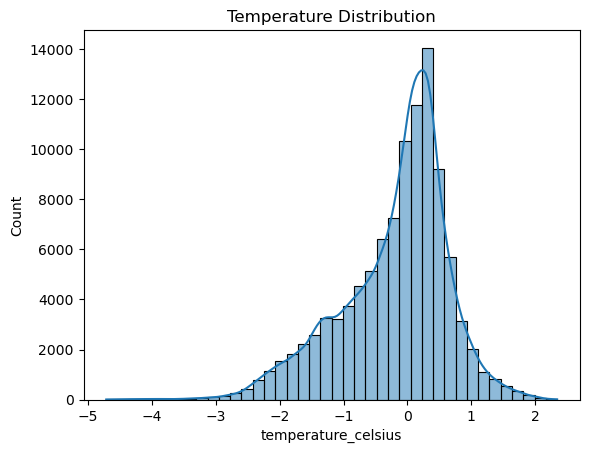

In [ ]:
sns.histplot(cleaned_df['temperature_celsius'], bins=40, kde=True)
plt.title("Temperature Distribution")
plt.show()


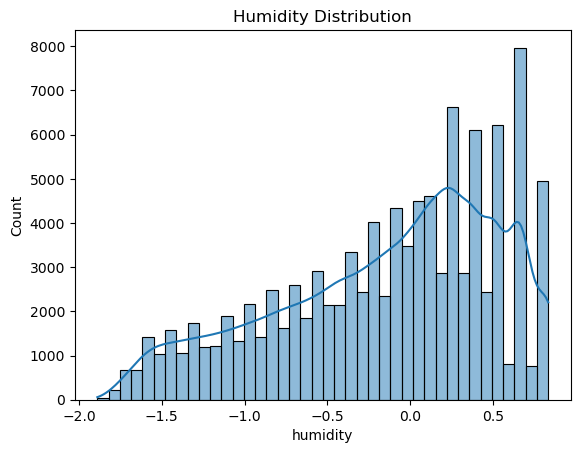

In [122]:
sns.histplot(cleaned_df['humidity'], kde=True, bins=40)
plt.title("Humidity Distribution")
plt.show()

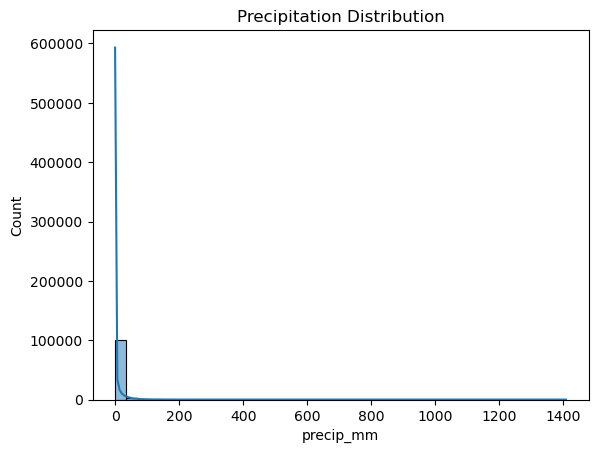

In [ ]:
sns.histplot(cleaned_df['precip_mm'], bins=40, kde=True)
plt.title("Precipitation Distribution")
plt.show()

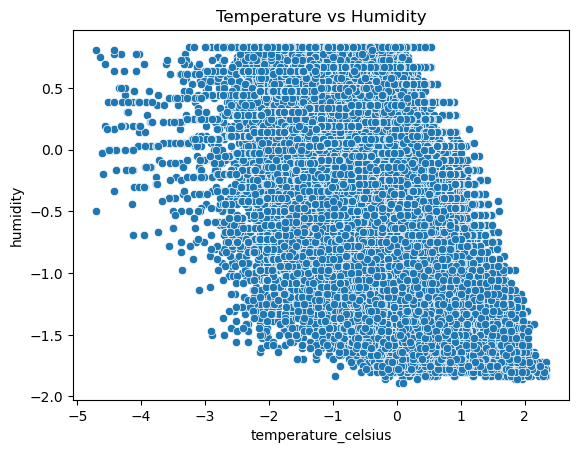

In [ ]:
sns.scatterplot(x=cleaned_df['temperature_celsius'], y=cleaned_df['humidity'])
plt.title("Temperature vs Humidity")
plt.show()

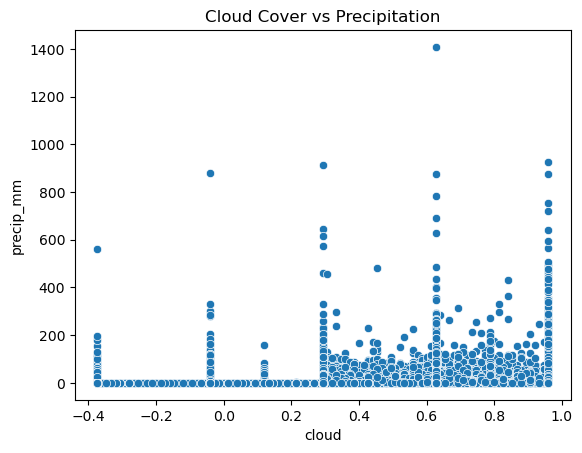

In [ ]:
sns.scatterplot(x=cleaned_df['cloud'], y=cleaned_df['precip_mm'])
plt.title("Cloud Cover vs Precipitation")
plt.show()


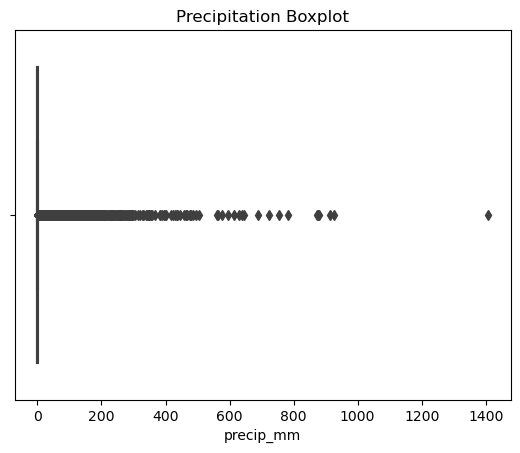

In [126]:
sns.boxplot(x=cleaned_df['precip_mm'])
plt.title("Precipitation Boxplot")
plt.show()

In [131]:
cleaned_df['last_updated'] = pd.to_datetime(cleaned_df['last_updated'], errors='coerce')
cleaned_df = cleaned_df.sort_values('last_updated')

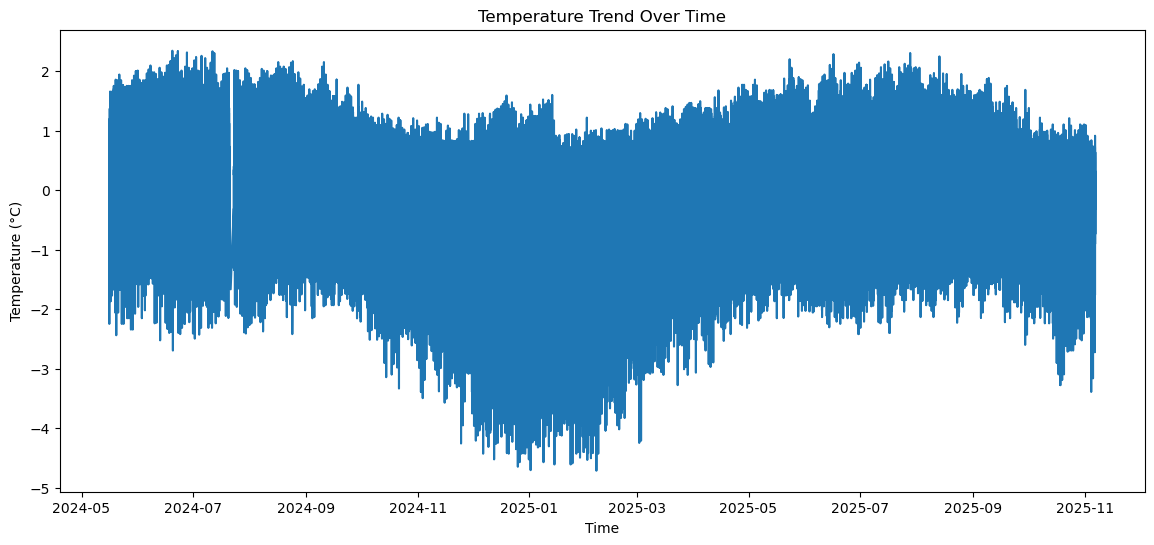

In [132]:
plt.figure(figsize=(14, 6))
plt.plot(cleaned_df['last_updated'], cleaned_df['temperature_celsius'])
plt.title("Temperature Trend Over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.show()

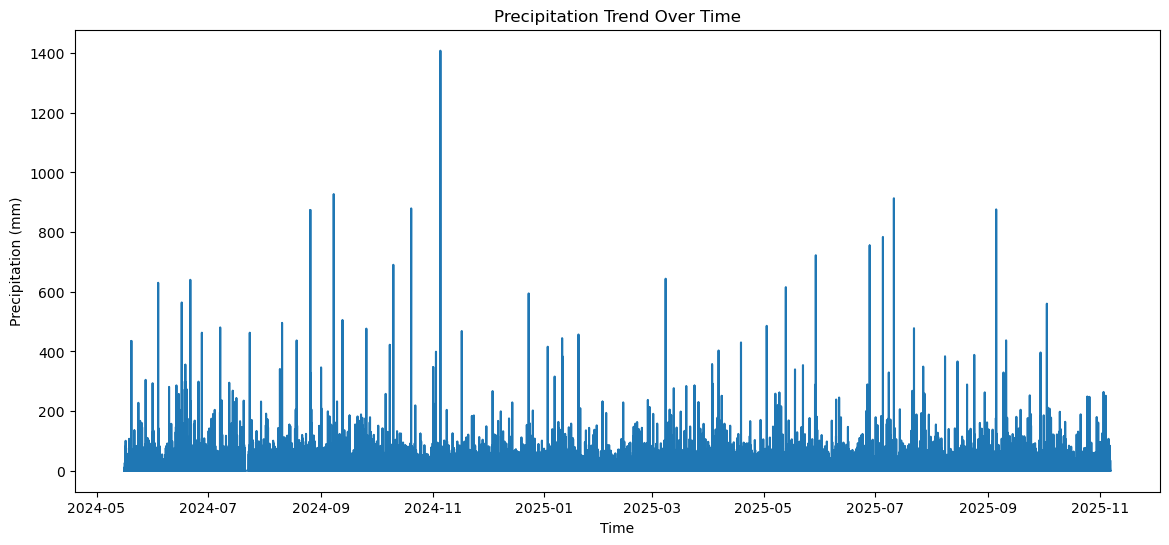

In [133]:
plt.figure(figsize=(14, 6))
plt.plot(cleaned_df['last_updated'], cleaned_df['precip_mm'])
plt.title("Precipitation Trend Over Time")
plt.xlabel("Time")
plt.ylabel("Precipitation (mm)")
plt.show()

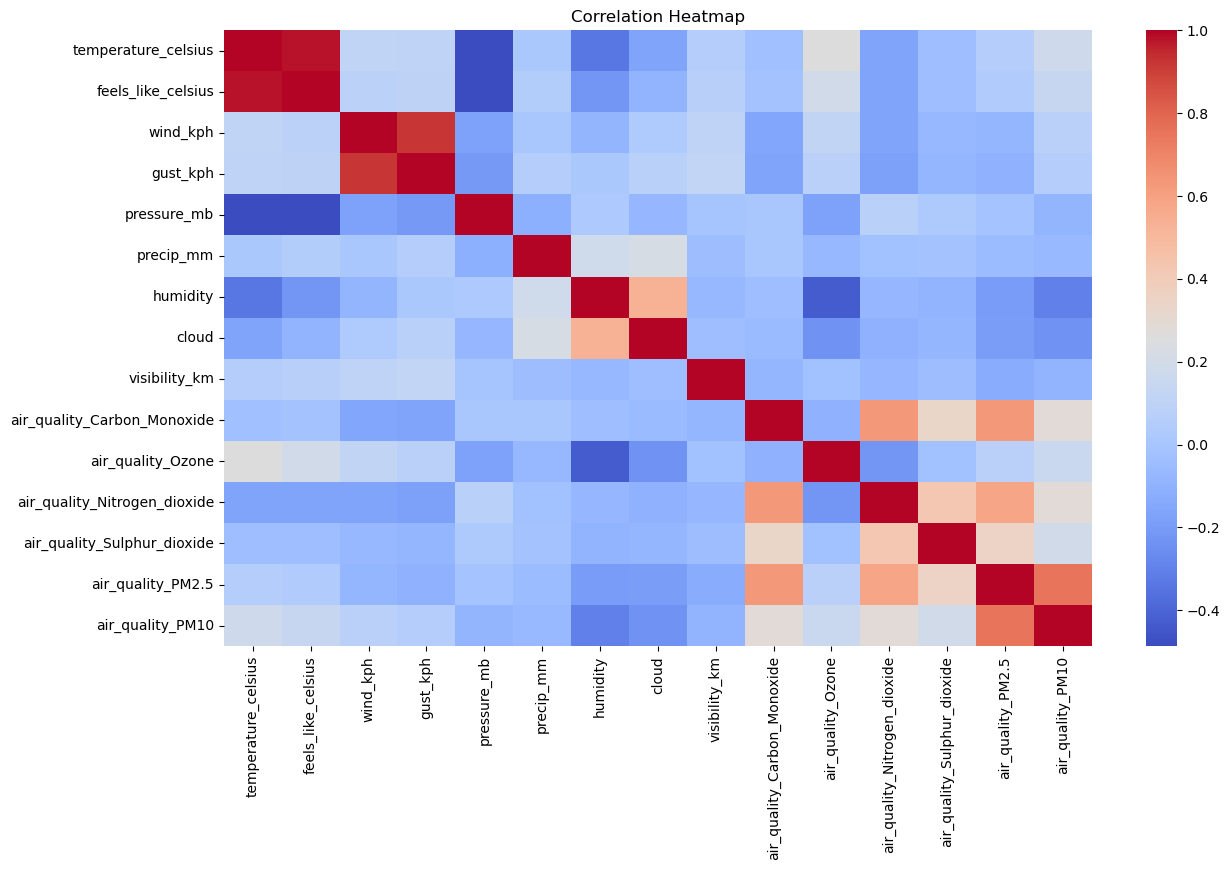

In [143]:
plt.figure(figsize=(14, 8))
sns.heatmap(cleaned_df[numeric_cols].corr(numeric_only=True), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

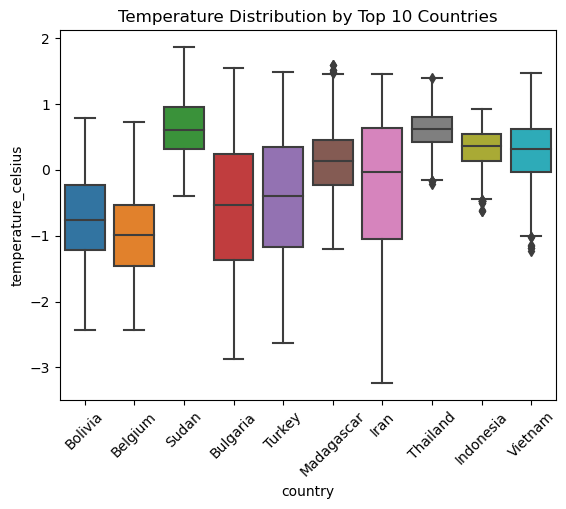

In [136]:
top_countries = cleaned_df['country'].value_counts().head(10).index
sns.boxplot(x=cleaned_df[cleaned_df['country'].isin(top_countries)]['country'],
            y=cleaned_df[cleaned_df['country'].isin(top_countries)]['temperature_celsius'])
plt.xticks(rotation=45)
plt.title("Temperature Distribution by Top 10 Countries")
plt.show()

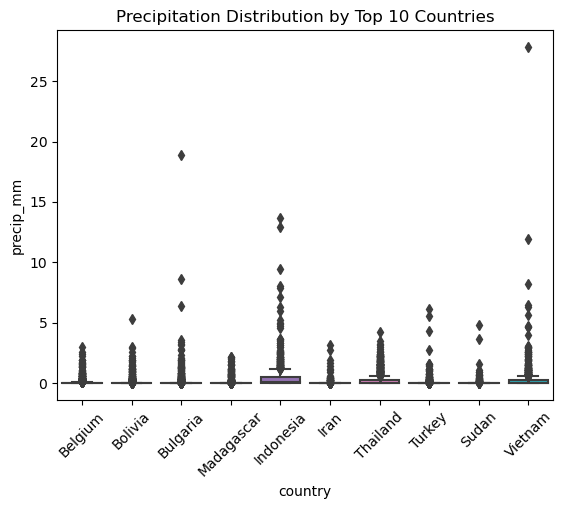

In [144]:
top_countries = cleaned_df['country'].value_counts().head(10).index
sns.boxplot(x=cleaned_df[cleaned_df['country'].isin(top_countries)]['country'],
            y=cleaned_df[cleaned_df['country'].isin(top_countries)]['precip_mm'])
plt.xticks(rotation=45)
plt.title("Precipitation Distribution by Top 10 Countries")
plt.show()

In [ ]:
def prepare_city_timeseries(city_name):
    df_city = cleaned_df[cleaned_df['location_name'] == city_name].copy()
    df_city['last_updated'] = pd.to_datetime(df_city['last_updated'], errors='coerce')
    df_city = df_city.sort_values('last_updated')

    ts = (
        df_city[['last_updated', 'temperature_celsius']]
        .set_index('last_updated')
        .resample('D')
        .mean()
        .ffill()
    )
    return ts

In [ ]:
city = "Kabul"
ts = prepare_city_timeseries(city)

plt.figure(figsize=(12, 5))
plt.plot(ts.index, ts['temperature_celsius'])
plt.title(f"{city} – Daily Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

train = ts.iloc[:-30]
test = ts.iloc[-30:]

print("Train size:", len(train))
print("Test size:", len(test))

model_arima = ARIMA(train, order=(5,1,0))
arima_fit = model_arima.fit()

forecast_arima = arima_fit.forecast(steps=30)
forecast_arima.index = test.index

mae_ar = mean_absolute_error(test, forecast_arima)
rmse_ar = mean_squared_error(test, forecast_arima)**0.5

plt.figure(figsize=(12,5))
plt.plot(train, label="Training")
plt.plot(test, label="Actual")
plt.plot(forecast_arima, label="ARIMA Forecast")
plt.title(f"{city} – ARIMA Forecast vs Actual")
plt.legend()
plt.show()

ts_prophet = ts.reset_index().rename(
    columns={'last_updated': 'ds', 'temperature_celsius': 'y'}
)

train_p = ts_prophet.iloc[:-30]
test_p  = ts_prophet.iloc[-30:]

model_p = Prophet()
model_p.fit(train_p)

future = model_p.make_future_dataframe(periods=30)
forecast_p = model_p.predict(future)

pred_p = (
    forecast_p[['ds', 'yhat']]
    .iloc[-30:]
    .set_index('ds')
)

actual_p = test_p.set_index('ds')

mae_p = mean_absolute_error(actual_p['y'], pred_p['yhat'])
rmse_p = mean_squared_error(actual_p['y'], pred_p['yhat'])**0.5

plt.figure(figsize=(12,5))
plt.plot(actual_p.index, actual_p['y'], label="Actual")
plt.plot(pred_p.index, pred_p['yhat'], label="Prophet Forecast")
plt.title(f"{city} – Prophet Forecast vs Actual")
plt.legend()
plt.show()

results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet"],
    "MAE": [mae_ar, mae_p],
    "RMSE": [rmse_ar, rmse_p]
})

print("\n Model Performance Summary:")
print(results)

Train size: 510
Test size: 30


16:49:54 - cmdstanpy - INFO - Chain [1] start processing
16:49:54 - cmdstanpy - INFO - Chain [1] done processing



✅ Model Performance Summary:
     Model       MAE      RMSE
0    ARIMA  2.484561  3.080204
1  Prophet  5.384561  5.921983


# Anomaly Analysis

In [185]:
city = "Bangkok"    
target_col = "temperature_celsius"

city_df = cleaned_df[cleaned_df['location_name'] == city].copy()

city_df['last_updated'] = pd.to_datetime(city_df['last_updated'], errors="coerce")
city_df = city_df.sort_values('last_updated')

ts = city_df.set_index("last_updated")[[target_col]]

Q1 = ts[target_col].quantile(0.25)
Q3 = ts[target_col].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

iqr_outliers = ts[(ts[target_col] < lower) | (ts[target_col] > upper)]

ts['zscore'] = (ts[target_col] - ts[target_col].mean()) / ts[target_col].std()
z_outliers = ts[np.abs(ts['zscore']) > 2.5]

ts['rolling_mean'] = ts[target_col].rolling(7).mean()
ts['rolling_std']  = ts[target_col].rolling(7).std()

ts['rolling_anomaly'] = np.abs(ts[target_col] - ts['rolling_mean']) > 2 * ts['rolling_std']
rolling_outliers = ts[ts['rolling_anomaly'] == True]

print(f"IQR anomalies detected: {len(iqr_outliers)}")
print(f"Z-score anomalies detected: {len(z_outliers)}")
print(f"Rolling-window anomalies detected: {len(rolling_outliers)}")
print(f"Total observations: {len(ts)}")

plt.figure(figsize=(14,6))
plt.plot(ts.index, ts[target_col], label="Time Series", alpha=0.7)

plt.scatter(iqr_outliers.index, iqr_outliers[target_col], 
            color="red", s=70, label="IQR Outliers")

plt.scatter(z_outliers.index, z_outliers[target_col], 
            color="orange", s=70, label="Z-score Outliers")

plt.scatter(rolling_outliers.index, rolling_outliers[target_col], 
            color="purple", s=70, label="Rolling Window Outliers")

plt.title(f"{city} – {target_col} Anomaly Detection")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend()
plt.show()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
IQR anomalies detected: 7
Z-score anomalies detected: 6
Rolling-window anomalies detected: 16
Total observations: 537


# Model Creation

In [165]:
city = "Abu Dhabi"
target_col = "temperature_celsius"
lags = [1,2,3,7,14]

numeric_cols = [
    "temperature_celsius","feels_like_celsius","wind_kph","gust_kph",
    "pressure_mb","precip_mm","humidity","cloud","visibility_km",
    "air_quality_Carbon_Monoxide","air_quality_Ozone",
    "air_quality_Nitrogen_dioxide","air_quality_Sulphur_dioxide",
    "air_quality_PM2.5","air_quality_PM10"
]



In [ ]:
df = cleaned_df[cleaned_df["location_name"] == city].copy()
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

ts = (
    df.set_index("last_updated")[numeric_cols]
      .resample("D")
      .mean()
      .ffill()
)

ts = ts[np.abs(zscore(ts[target_col])) < 3]



In [167]:
for lag in lags:
    ts[f"lag_{lag}"] = ts[target_col].shift(lag)

ts["ma_7"] = ts[target_col].rolling(7).mean()
ts["ma_14"] = ts[target_col].rolling(14).mean()
ts["std_7"] = ts[target_col].rolling(7).std()
ts["exp_mean"] = ts[target_col].expanding().mean()

ts["day"] = ts.index.day
ts["month"] = ts.index.month
ts["weekday"] = ts.index.weekday
ts["year"] = ts.index.year
ts["month_sin"] = np.sin(2*np.pi * ts["month"]/12)
ts["month_cos"] = np.cos(2*np.pi * ts["month"]/12)

ts = ts.dropna()

In [168]:
feature_cols = (
    numeric_cols +
    ["ma_7","ma_14","std_7","exp_mean","day","month","weekday","year","month_sin","month_cos"] +
    [f"lag_{lag}" for lag in lags]
)

X = ts[feature_cols]
y = ts[target_col]

In [169]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=feature_cols,
    index=X.index
)

In [170]:
train_size = int(len(ts) * 0.9)
X_train, X_test = X_scaled.iloc[:train_size], X_scaled.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [184]:
def forecast_future(ts, models, scaler, feature_cols, target_col, lags, steps=30, weights=None):
    future_df = ts.copy()

    for step in range(steps):
        last_row = future_df.iloc[-1:].copy()
        new_date = last_row.index[0] + pd.Timedelta(days=1)

        new_row = last_row.copy()
        new_row.index = [new_date]

        new_row["day"] = new_date.day
        new_row["month"] = new_date.month
        new_row["weekday"] = new_date.weekday()
        new_row["year"] = new_date.year
        new_row["month_sin"] = np.sin(2*np.pi * new_date.month/12)
        new_row["month_cos"] = np.cos(2*np.pi * new_date.month/12)

        for lag in lags:
            new_row[f"lag_{lag}"] = future_df[target_col].iloc[-lag]
        new_row["ma_7"]  = future_df[target_col].rolling(7).mean().iloc[-1]
        new_row["ma_14"] = future_df[target_col].rolling(14).mean().iloc[-1]
        new_row["std_7"] = future_df[target_col].rolling(7).std().iloc[-1]
        new_row["exp_mean"] = future_df[target_col].expanding().mean().iloc[-1]

        x_scaled = scaler.transform(new_row[feature_cols])
        new_row[target_col] = models[target_col].predict(x_scaled)[0]

        future_df = pd.concat([future_df, new_row])

    return future_df.tail(steps)[target_col]

In [ ]:
models = {}

for col in numeric_cols:
    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, ts[col].iloc[:train_size])
    models[col] = model

test_temp_pred = models[target_col].predict(X_test)

mae = mean_absolute_error(y_test, test_temp_pred)
rmse = mean_squared_error(y_test, test_temp_pred) ** 0.5
print(f"\n TEST Forecast — {city}")
print("MAE :", mae)
print("RMSE:", rmse)

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, test_temp_pred, label="Predicted")
plt.title(f"{city} — Temperature Prediction (Test)")
plt.legend()
plt.show()

future_df = ts.copy()

xgb_forecast = forecast_future(
    ts, models, scaler, feature_cols, target_col, lags, steps=30
)

plt.figure(figsize=(14,6))
plt.plot(ts.index, ts[target_col], label="Historical")
plt.plot(xgb_forecast.index, xgb_forecast, label="XGBoost 30-Day Forecast", linewidth=2)
plt.title(f"{city} — XGBoost 30-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


 TEST Forecast — Bangkok
MAE : 0.22760162353515592
RMSE: 0.2935351372510725


In [181]:
rf_models = {}

for col in numeric_cols:
    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, ts[col].iloc[:train_size])
    rf_models[col] = model

rf_test_pred = rf_models[target_col].predict(X_test)

mae = mean_absolute_error(y_test, rf_test_pred)
rmse = mean_squared_error(y_test, rf_test_pred) ** 0.5
print("\n Random Forest Temperature (Test Set)")
print("MAE :", mae)
print("RMSE:", rmse)


plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, rf_test_pred, label="RF Predicted")
plt.title(f"{city} — Random Forest Test Prediction")
plt.legend()
plt.show()

future_df = ts.copy()

rf_forecast = forecast_future(
    ts, rf_models, scaler, feature_cols, target_col, lags, steps=30
)

plt.figure(figsize=(14,6))
plt.plot(ts.index, ts[target_col], label="Historical")
plt.plot(rf_forecast.index, rf_forecast, label="Random Forest 30-Day Forecast", linewidth=2)
plt.title(f"{city} — Random Forest 30-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


 Random Forest Temperature (Test Set)
MAE : 0.036418867924510726
RMSE: 0.05032546900113604


d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was

## Climate analysis

In [ ]:
city = "Abu Dhabi"
df = cleaned_df[cleaned_df["location_name"] == city].copy()
df["last_updated"] = pd.to_datetime(df["last_updated"])
df_numeric = df.set_index("last_updated")[numeric_cols]
daily = df_numeric.resample("D").mean()
annual = daily.resample("Y").mean()

plt.figure(figsize=(14,5))
plt.plot(annual.index, annual["temperature_celsius"], marker='o', label="Temperature (°C)")
plt.title(f"{city} — Annual Temperature Trend")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(annual.index, annual["precip_mm"], marker='o', color='blue', label="Precipitation (mm)")
plt.title(f"{city} — Annual Precipitation Trend")
plt.ylabel("Precipitation (mm)")
plt.grid()
plt.legend()
plt.show()


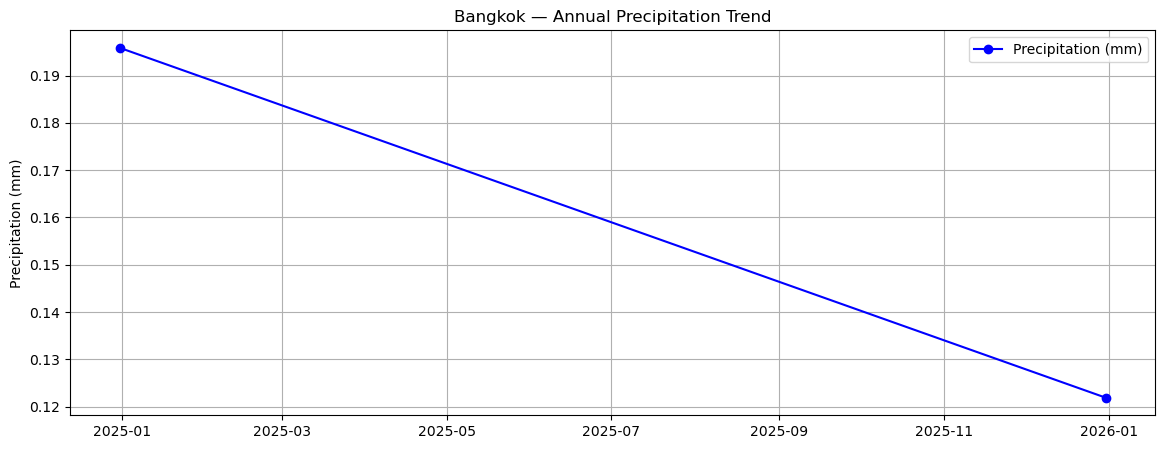

In [ ]:
city = "Bangkok"
df = cleaned_df[cleaned_df["location_name"] == city].copy()
df["last_updated"] = pd.to_datetime(df["last_updated"])
df_numeric = df.set_index("last_updated")[numeric_cols]
daily = df_numeric.resample("D").mean()
annual = daily.resample("Y").mean()

plt.figure(figsize=(14,5))
plt.plot(annual.index, annual["temperature_celsius"], marker='o', label="Temperature (°C)")
plt.title(f"{city} — Annual Temperature Trend")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(annual.index, annual["precip_mm"], marker='o', color='blue', label="Precipitation (mm)")
plt.title(f"{city} — Annual Precipitation Trend")
plt.ylabel("Precipitation (mm)")
plt.grid()
plt.legend()
plt.show()


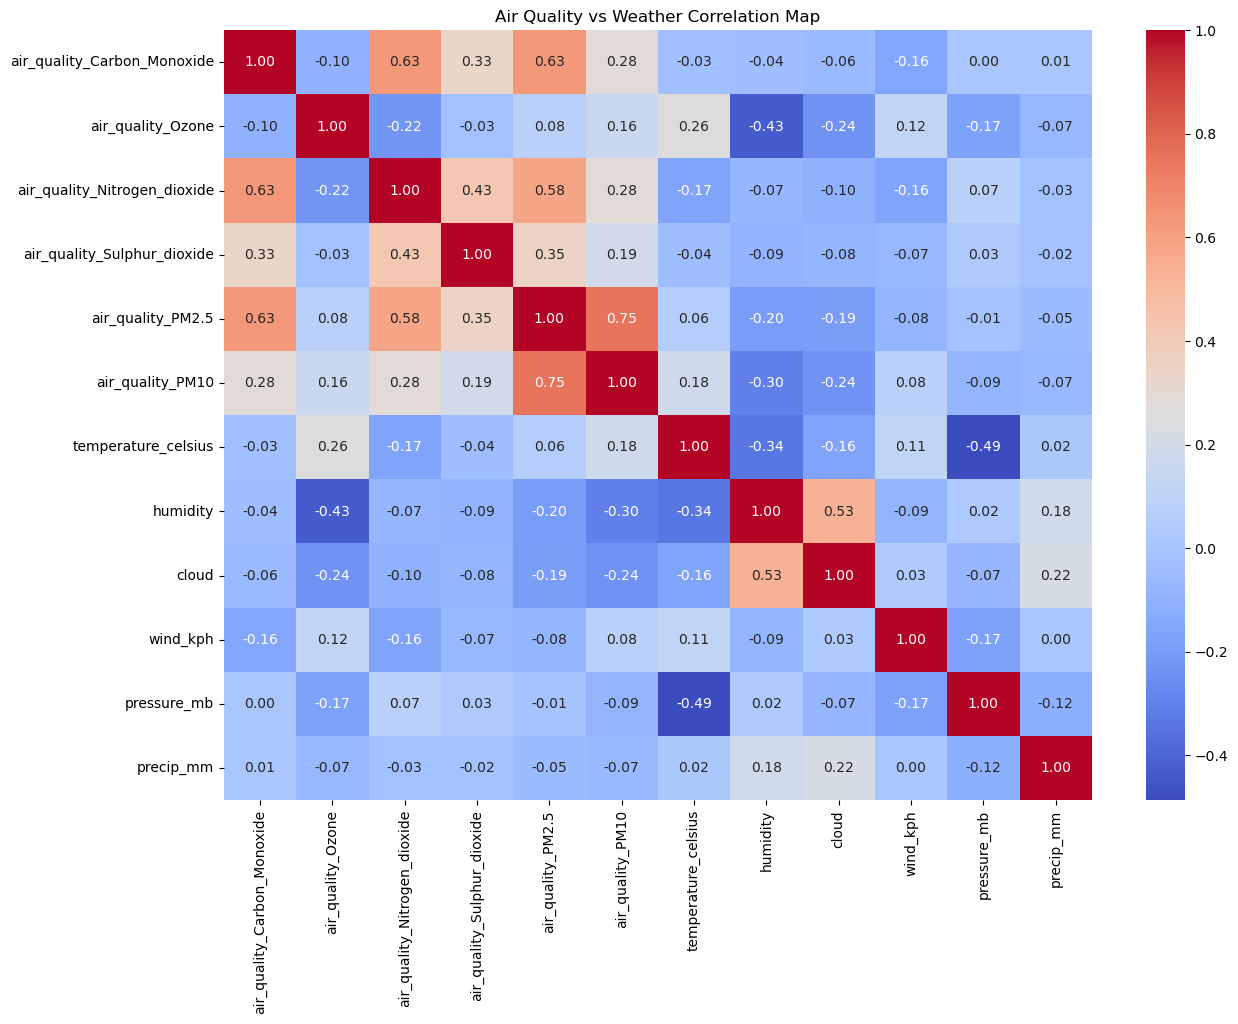

In [ ]:
aq_cols = [
    "air_quality_Carbon_Monoxide", "air_quality_Ozone",
    "air_quality_Nitrogen_dioxide", "air_quality_Sulphur_dioxide",
    "air_quality_PM2.5", "air_quality_PM10"
]

weather_cols = [
    "temperature_celsius", "humidity", "cloud",
    "wind_kph", "pressure_mb", "precip_mm"
]

subset = cleaned_df[aq_cols + weather_cols].copy()

corr = subset.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Air Quality vs Weather Correlation Map")
plt.show()